# XOR

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 

In [2]:
# get train data
def get_data(filename):
    elements = np.zeros((4, 3),dtype=float)  #先建立一個 4x3的全零方陣A，並且資料的型別設定為float浮點型
    f = open(filename)        #開啟資料檔案檔案
    lines = f.readlines()      #把全部資料檔案讀到一個列表lines中
    row = 0            #矩陣的行，從0行開始
    lineNum = 0
    for line in lines:       #把lines中的資料逐行讀取出來
        if(lineNum==0):    
            lineNum += 1
            continue
        list = line.strip('\n').split('\t') #處理逐行資料：strip表示把頭尾的'\n'去掉，split表示以\t分割行資料，然後把處理後的行資料返回到list列表中
        elements[row:] = list[0:3]        #把處理後的資料放到方陣A中。list[0:3]表示列表的0~2列資料放到矩陣中的row行
        row += 1
    f.close()
    return elements #回傳矩陣資料

# activation function
def sigmoid(x):
    return  1 / (1 + np.exp(-x))

# output activation function
def softmax(x):
    x = x - np.max(x)
    return np.exp(x) / np.sum(np.exp(x))

# 所有訓練資料的y、所有訓練資料的t
def cross_entropy_error(y, t):
    return -np.sum(t * np.log(y + 1e-7))  #log(0)為負無限大，所以要加上微小值 1e-7

def numerical_gradient(f, x):     
    h = 1e-4 # 0.0001
    grad = np.zeros_like(x)
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite']) 
    #numpy的迭代器，multi_index：多重索引[輸出：就是陣列索引號（0,0）（0,1）等]; readwrite：對x有可讀可寫的許可權
    while not it.finished:
        idx = it.multi_index
        
        #偏微分
        tmp_val = x[idx]
        x[idx] = float(tmp_val) + h
        fxh1 = f(x) # f(x+h)
        
        x[idx] = tmp_val - h 
        fxh2 = f(x) # f(x-h)
        grad[idx] = (fxh1 - fxh2) / (2*h)
        
        x[idx] = tmp_val 
        it.iternext()        
    return grad

# 兩層感知器-XOR

In [3]:
class TwoLayerPerceptron:
    def __init__(self, learnRate):    
        self.w1 = np.random.randn(2 + 1, 2)
        self.w2 = np.random.randn(2 + 1, 1)
#         self.w1 = np.array([[0.90, -0.41], [0.07, 1.39], [1.49, -0.95]])
#         self.w2 = np.array([[0.27], [-0.74], [-1.64]])
        print('w1', self.w1, '\nw2', self.w2)
        
        self.lr = learnRate
        
    def predict(self, x):    
        W1, W2 = self.w1, self.w2

        a1 = np.dot(x, W1)  
        z1 = np.hstack([sigmoid(a1), 1])
        a2 = np.dot(z1, W2)
        self.y = sigmoid(a2)  #softmax sigmoid
    
        return self.y
        
    # x:input data x, t:train weight
    def loss(self, x, t):
        y = self.predict(x)
#         return abs(y-t) 
        return np.sum((y-t)**2) #mse
#         return cross_entropy_error(y, t)

    # x:input data x, t:train weight
    def gradient(self, x, t):
        loss_W = lambda w: self.loss(x, t)
        
        grads = {}
        grads['w1'] = numerical_gradient(loss_W, self.w1)  
        grads['w2'] = numerical_gradient(loss_W, self.w2)
        
        return grads  
        
    def mse(self, t):
        return (t-self.y)**2
    
    def test(self, x, t):
        print("XOR test-> ")
        for i in range(len(x)):
            X = np.array(x[i])
            Y = self.predict(X)
            print('\t', X, '--> t:', t[i], '\ty:', Y)
    
    def drawFig(self, title, x1, x2):
        plt.grid(True, linestyle='-')
        
        plt.title(title + " Gate")
        plt.xlabel("x1")
        plt.ylabel("x2")
        
        w = self.w1
        X = np.arange(-1,2,0.1)
        
        # 第一層感知器
        Y1 = (-w[2][0]-w[0][0]*X)/w[1][0]
        plt.plot(X,Y1, color='blue') 
        lineName = r'Perceptron1:\n{0:.3f}*x1 + {1:.3f}*x2 + {2:.3f} = 0'.format(w[0][0], w[1][0], w[2][0])
        plt.annotate(lineName, xy=(0.3, (-w[2][0]-w[0][0]*0.3)/w[1][0]), xytext=(0.7, (-w[2][0]-w[0][0]*0.5)/w[1][0]-0.6),
            arrowprops=dict(facecolor='lightblue', shrink=0.05))
        
        # 第二層感知器
        Y2 = (-w[2][1]-w[0][1]*X)/w[1][1]
        plt.plot(X,Y2, color='red') 
        lineName = r'Perceptron2:\n{0:.3f}*x1 + {1:.3f}*x2 + {2:.3f} = 0'.format(w[0][1], w[1][1], w[2][1])  
        plt.annotate(lineName, xy=(0.3, (-w[2][1]-w[0][1]*0.3)/w[1][1]), xytext=(0.7, (-w[2][1]-w[0][1]*0.5)/w[1][1]-0.6),
            arrowprops=dict(facecolor='lightpink', shrink=0.05))

        
        plt.fill_between(X, Y1, Y2, color='gray', alpha='0.8')
        
        # 測試資料
        plt.scatter(np.array([0,1]), np.array([0,1]), color='y', marker='o', label='target=0')
        plt.scatter(np.array([0,1]), np.array([1,0]), color='g', marker='*', label='target=1')
        plt.legend(loc = 'upper right')
        for xy in zip(x1, x2):
            plt.annotate("P(%d,%d)" % xy, xy=xy, xytext=(-20, 10), textcoords='offset points')
        
        plt.savefig('xor.png')
        plt.show()    
        
    def drawFig2(self, title, lossArr):
        plt.title(title)
        x = np.arange(0, len(lossArr), 1)
        plt.plot(x, lossArr[x], label='loss')
        plt.xlabel("epochs")
        plt.ylabel("loss")
        plt.ylim(0, 1.0)
        plt.legend(loc='upper right')
        plt.savefig('train_loss.png')
        plt.show()

input learnRate: 0.9
epoch: 50000
w1 [[-0.58160968 -0.07593323]
 [-1.39735912  0.39943913]
 [-0.41629812 -0.02210136]] 
w2 [[0.53643299]
 [0.07280992]
 [0.09424002]]
Epoch: 0 	 loss: [0.29227437]
Epoch: 1 	 loss: [0.29248137]
Epoch: 2 	 loss: [0.29246394]
Epoch: 3 	 loss: [0.29231297]
Epoch: 4 	 loss: [0.29208634]
Epoch: 5 	 loss: [0.29181942]
Epoch: 6 	 loss: [0.29153337]
Epoch: 7 	 loss: [0.29124065]
Epoch: 8 	 loss: [0.29094848]
Epoch: 9 	 loss: [0.29066101]
Epoch: 10 	 loss: [0.2903805]
Epoch: 11 	 loss: [0.29010815]
Epoch: 12 	 loss: [0.28984448]
Epoch: 13 	 loss: [0.28958968]
Epoch: 14 	 loss: [0.28934369]
Epoch: 15 	 loss: [0.28910632]
Epoch: 16 	 loss: [0.28887733]
Epoch: 17 	 loss: [0.28865641]
Epoch: 18 	 loss: [0.28844327]
Epoch: 19 	 loss: [0.28823759]
Epoch: 20 	 loss: [0.28803906]
Epoch: 21 	 loss: [0.28784735]
Epoch: 22 	 loss: [0.28766218]
Epoch: 23 	 loss: [0.28748325]
Epoch: 24 	 loss: [0.28731028]
Epoch: 25 	 loss: [0.28714298]
Epoch: 26 	 loss: [0.2869811]
Epoch: 27

Epoch: 271 	 loss: [0.18282491]
Epoch: 272 	 loss: [0.18248128]
Epoch: 273 	 loss: [0.1821365]
Epoch: 274 	 loss: [0.18179056]
Epoch: 275 	 loss: [0.18144345]
Epoch: 276 	 loss: [0.18109517]
Epoch: 277 	 loss: [0.18074573]
Epoch: 278 	 loss: [0.18039514]
Epoch: 279 	 loss: [0.18004343]
Epoch: 280 	 loss: [0.17969062]
Epoch: 281 	 loss: [0.17933675]
Epoch: 282 	 loss: [0.17898186]
Epoch: 283 	 loss: [0.17862599]
Epoch: 284 	 loss: [0.1782692]
Epoch: 285 	 loss: [0.17791154]
Epoch: 286 	 loss: [0.17755307]
Epoch: 287 	 loss: [0.17719385]
Epoch: 288 	 loss: [0.17683395]
Epoch: 289 	 loss: [0.17647344]
Epoch: 290 	 loss: [0.17611238]
Epoch: 291 	 loss: [0.17575086]
Epoch: 292 	 loss: [0.17538893]
Epoch: 293 	 loss: [0.17502668]
Epoch: 294 	 loss: [0.17466418]
Epoch: 295 	 loss: [0.17430149]
Epoch: 296 	 loss: [0.17393868]
Epoch: 297 	 loss: [0.17357583]
Epoch: 298 	 loss: [0.17321298]
Epoch: 299 	 loss: [0.17285021]
Epoch: 300 	 loss: [0.17248756]
Epoch: 301 	 loss: [0.17212508]
Epoch: 302

Epoch: 530 	 loss: [0.00670844]
Epoch: 531 	 loss: [0.00665866]
Epoch: 532 	 loss: [0.00660957]
Epoch: 533 	 loss: [0.00656116]
Epoch: 534 	 loss: [0.0065134]
Epoch: 535 	 loss: [0.00646629]
Epoch: 536 	 loss: [0.00641981]
Epoch: 537 	 loss: [0.00637395]
Epoch: 538 	 loss: [0.00632871]
Epoch: 539 	 loss: [0.00628406]
Epoch: 540 	 loss: [0.00623999]
Epoch: 541 	 loss: [0.00619651]
Epoch: 542 	 loss: [0.00615358]
Epoch: 543 	 loss: [0.00611121]
Epoch: 544 	 loss: [0.00606939]
Epoch: 545 	 loss: [0.0060281]
Epoch: 546 	 loss: [0.00598733]
Epoch: 547 	 loss: [0.00594708]
Epoch: 548 	 loss: [0.00590733]
Epoch: 549 	 loss: [0.00586807]
Epoch: 550 	 loss: [0.00582931]
Epoch: 551 	 loss: [0.00579102]
Epoch: 552 	 loss: [0.0057532]
Epoch: 553 	 loss: [0.00571584]
Epoch: 554 	 loss: [0.00567894]
Epoch: 555 	 loss: [0.00564248]
Epoch: 556 	 loss: [0.00560646]
Epoch: 557 	 loss: [0.00557087]
Epoch: 558 	 loss: [0.0055357]
Epoch: 559 	 loss: [0.00550094]
Epoch: 560 	 loss: [0.0054666]
Epoch: 561 	 

Epoch: 799 	 loss: [0.00211928]
Epoch: 800 	 loss: [0.00211366]
Epoch: 801 	 loss: [0.00210807]
Epoch: 802 	 loss: [0.0021025]
Epoch: 803 	 loss: [0.00209697]
Epoch: 804 	 loss: [0.00209146]
Epoch: 805 	 loss: [0.00208599]
Epoch: 806 	 loss: [0.00208053]
Epoch: 807 	 loss: [0.00207511]
Epoch: 808 	 loss: [0.00206971]
Epoch: 809 	 loss: [0.00206434]
Epoch: 810 	 loss: [0.002059]
Epoch: 811 	 loss: [0.00205368]
Epoch: 812 	 loss: [0.00204839]
Epoch: 813 	 loss: [0.00204313]
Epoch: 814 	 loss: [0.00203789]
Epoch: 815 	 loss: [0.00203268]
Epoch: 816 	 loss: [0.00202749]
Epoch: 817 	 loss: [0.00202233]
Epoch: 818 	 loss: [0.00201719]
Epoch: 819 	 loss: [0.00201208]
Epoch: 820 	 loss: [0.00200699]
Epoch: 821 	 loss: [0.00200193]
Epoch: 822 	 loss: [0.00199689]
Epoch: 823 	 loss: [0.00199188]
Epoch: 824 	 loss: [0.00198689]
Epoch: 825 	 loss: [0.00198192]
Epoch: 826 	 loss: [0.00197698]
Epoch: 827 	 loss: [0.00197206]
Epoch: 828 	 loss: [0.00196717]
Epoch: 829 	 loss: [0.0019623]
Epoch: 830 	

Epoch: 1067 	 loss: [0.00122593]
Epoch: 1068 	 loss: [0.00122397]
Epoch: 1069 	 loss: [0.00122202]
Epoch: 1070 	 loss: [0.00122007]
Epoch: 1071 	 loss: [0.00121813]
Epoch: 1072 	 loss: [0.00121619]
Epoch: 1073 	 loss: [0.00121426]
Epoch: 1074 	 loss: [0.00121234]
Epoch: 1075 	 loss: [0.00121042]
Epoch: 1076 	 loss: [0.00120851]
Epoch: 1077 	 loss: [0.0012066]
Epoch: 1078 	 loss: [0.0012047]
Epoch: 1079 	 loss: [0.00120281]
Epoch: 1080 	 loss: [0.00120092]
Epoch: 1081 	 loss: [0.00119903]
Epoch: 1082 	 loss: [0.00119716]
Epoch: 1083 	 loss: [0.00119529]
Epoch: 1084 	 loss: [0.00119342]
Epoch: 1085 	 loss: [0.00119156]
Epoch: 1086 	 loss: [0.0011897]
Epoch: 1087 	 loss: [0.00118785]
Epoch: 1088 	 loss: [0.00118601]
Epoch: 1089 	 loss: [0.00118417]
Epoch: 1090 	 loss: [0.00118234]
Epoch: 1091 	 loss: [0.00118051]
Epoch: 1092 	 loss: [0.00117869]
Epoch: 1093 	 loss: [0.00117687]
Epoch: 1094 	 loss: [0.00117506]
Epoch: 1095 	 loss: [0.00117326]
Epoch: 1096 	 loss: [0.00117146]
Epoch: 1097 	

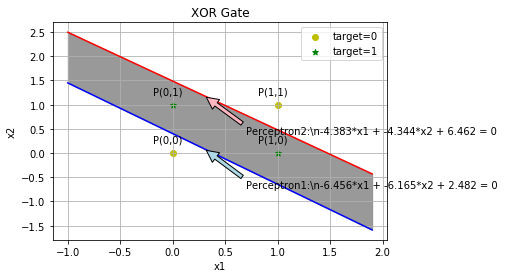

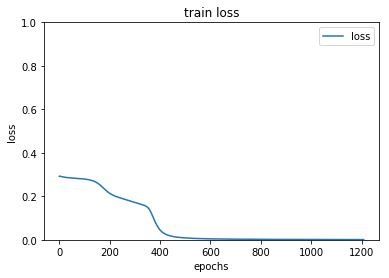

In [4]:
if __name__ == "__main__":
    filename = 'trainData/XOR_in.txt'
    data = get_data(filename)
    x = np.delete(data, -1, axis=1) # 刪除最後一列後得到x1、x2
    x = np.hstack([x,np.ones((4,1), dtype='int16')])  # 放入b，建立4*1全1陣列
    t = np.hsplit(data, 3)[2].ravel() # 取得最後一列，並轉成一維陣列
    lr = float(input('input learnRate: '))
    epoch = int(input('epoch: ')) 
    network = TwoLayerPerceptron(lr)
            
    ''' train '''
    train_loss_list = []
    for j in range(epoch):        
        lossMse = 0
        for index,X in enumerate(x):
            grad = network.gradient(X, t[index])
            network.w1 -= lr * grad['w1'] #  network.b1 = network.b1 - lr * grad['b1'] 
            network.w2 -= lr * grad['w2'] #  network.b2 = network.b2 - lr * grad['b2'] 
            
            lossMse += network.mse(t[index])
            
        lossMse = lossMse / len(x)
        print('Epoch:', j, '\t loss:', lossMse)
        
        train_loss_list.append(lossMse[0])
        
        if(lossMse<=0.001):
            break
        
    print('  final_w1: ', network.w1, '\n  final_w2: ', network.w2)
    network.test(x, t)
    network.drawFig("XOR", np.hsplit(x, 3)[0].ravel() , np.hsplit(data, 3)[1].ravel()) 
    network.drawFig2("train loss", np.array(train_loss_list))